# Julia

### Many thanks to Diego Castañeda for writing much of the code in this notebook.

As languages go, [installing Julia](http://julialang.org/downloads/platform.html) is a piece of cake. You also need [IJulia](https://github.com/JuliaLang/IJulia.jl) to run this notebook. You will also need to instal the PyPlot package, ToeplitzMatrices and MultivariateStats:

    Pkg.add("PyPlot")
    Pkg.add("MultivariateStats")
    Pkg.clone("https://github.com/JuliaMatrices/ToeplitzMatrices.jl.git")

I'm using Julia v0.5. 

## Some preliminary functions

[Basic array help.](http://docs.julialang.org/en/release-0.5/manual/arrays/)

[The linalg help is here.](http://docs.julialang.org/en/release-0.5/stdlib/linalg/)

In [1]:
using PyPlot

In [2]:
function norm(m)
    return m' * m
end

function misfit(d, d_pred)
    misfit = (d_pred .- d)' * (d_pred .- d)
    return misfit[1]
end

misfit (generic function with 1 method)

In [3]:
function plot_all(m, d, m_est, d_pred)
    #=
    Helper function for plotting. You can ignore this.
    =#
    
    fig = figure(figsize=(10,6))

    ax0 = fig[:add_subplot](2,2,1)
    ax0[:plot](m)
    t = L"$\mathrm{Model}$"
    ax0[:set_title](t)
    ax0_mi, ax0_ma = ax0[:get_ylim]()

    ax1 = fig[:add_subplot](2,2,2)
    ax1[:plot](d, "o", mew=0)
    ax1[:set_title](L"$\mathrm{Data}\ d$")
    ax1_mi, ax1_ma = ax1[:get_ylim]()
    
    ax2 = fig[:add_subplot](2,2,3)
    ax2[:plot](m, alpha=0.25)
    ax2[:plot](m_est)
    t = L"$\mathrm{Estimated\, model}$"
    ax2[:set_title](t)
    ax2_mi, ax2_ma = ax2[:get_ylim]()
    
    ax3 = fig[:add_subplot](2,2,4)
    ax3[:plot](d, "o", mew=0, alpha=0.25)
    ax3[:plot](d_pred, "o", mew=0)
    t = L"$\mathrm{{Predicted\ data}}$"
    ax3[:set_title](t)
    ax3_mi, ax3_ma = ax3[:get_ylim]()
    
    show()
end

plot_all (generic function with 1 method)

We can add a user made library to generate Toeplitz matrices: Pkg.clone("https://github.com/JuliaMatrices/ToeplitzMatrices.jl.git")

In [4]:
using ToeplitzMatrices
function convmtx(h, n)
    #=
    Equivalent of MATLAB's convmtx function, http://www.mathworks.com/help/signal/ref/convmtx.html.
    
    Makes the convolution matrix, C. The product C.x is the convolution of h and x.
    
    Args
        h (ndarray): a 1D array, the kernel.
        n (int): the number of rows to make.
        
    Returns
        ndarray. Size m+n-1
    =#
    col_1 = append!([h[1]],zeros(n-1))
    row_1 = append!(h,zeros(n-1))
    return Toeplitz(col_1, row_1)
end

convmtx (generic function with 1 method)

In [13]:
# Implements bruges's ricker.
function ricker(f=25, length=0.128, dt=0.001)

    # Time basis.
    t = collect(0:dt:length) .- length/2
    
    # Amplitudes.
    x = 1 - 2 * pi^2 * f^2 .* t.^2
    y = exp(-pi^2 * f^2 .* t.^2)
    a = x .* y

    return t, a
end

ricker (generic function with 4 methods)

## Construct the model

In [6]:
M = 50

#                    VP    RHO
m_ = ones((M, 1)) * 2550 * 2650  
m_[11:15,:] =       2700 * 2750   
m_[16:27,:] =       2400 * 2450
m_[28:35,:] =       2800 * 3000

8400000

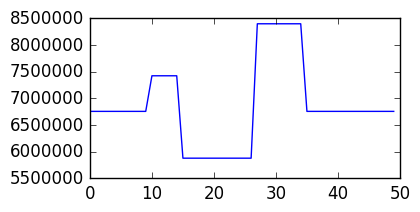

In [7]:
figure(figsize=(4,2))
plot(m_)
show()

In [8]:
ε = 1e-9; # Small float to avoid division by zero.
m = (m_[2:end] .- m_[1:end-1]) ./ (m_[2:end] .+ m_[1:end-1] .+ ε);

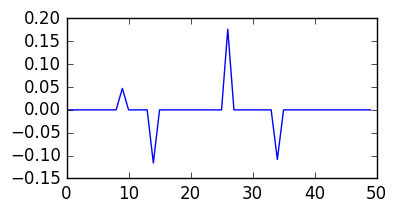

In [9]:
m = append!(m, 0)
figure(figsize=(4,2))
plot(m)
show()

## Forward operator: convolution with wavelet

Now we make the kernel matrix **G**, which represents convolution with a Ricker wavelet, plus a downsampling to ensure we are trying to solve an underdetermined problem, which is representative of many (most) inverse problems in geophysics.

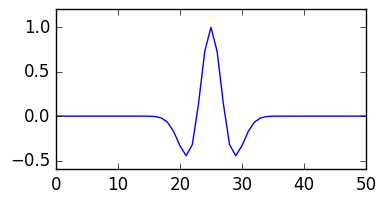

In [14]:
_, wavelet = ricker(100, 0.05, 0.001)
figure(figsize=(4,2))
plot(wavelet)
show()

Now we can use the `convmtx` function we defined earlier, selecting only the data we want — every other row, and only columns 26 to 75.

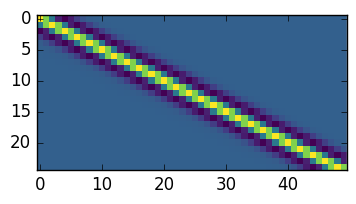

In [15]:
G = convmtx(wavelet, size(m)[1])[1:2:end, 26:75]
figure(figsize=(4,4))
imshow(G,cmap="viridis", interpolation="none")
show()

## Generate the data

In [16]:
d = G * m;

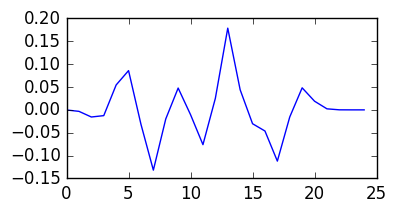

In [17]:
figure(figsize=(4,2))
plot(d)
show()

### Aside: an illustration of Gm = d

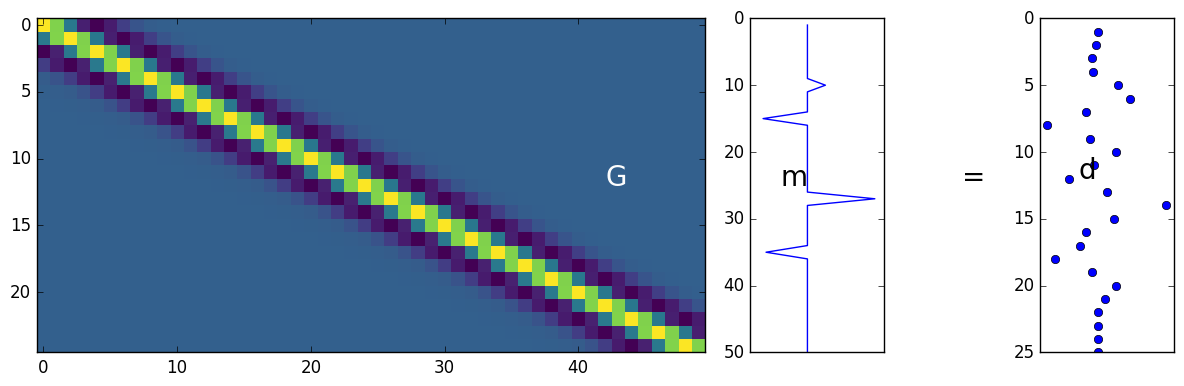

In [18]:
using PyCall
@pyimport matplotlib.gridspec as gridspec

fig = figure(figsize=(12, 4))

gs = gridspec.GridSpec(1, 4,width_ratios=[10, 2, 1, 2])

ax0 = subplot(get(gs, (0)))
ax0[:imshow](G, cmap="viridis", interpolation="none", aspect="auto")
ax0[:text](42, 12, "G", color="w", size=20)

y = collect(1:50)

ax1 = subplot(get(gs, (1)))
ax1[:plot](m, y)
ax1[:text](-0.07, 25, "m", color="k", size=20)
ax1[:set_xticks]([])
ax1[:invert_yaxis]()

ax2 = subplot(get(gs, (2)))
ax2[:set_frame_on](false)
ax2[:set_xticks]([])
ax2[:set_yticks]([])
ax2[:text](0.5, 0.5, "=", color="k", size=20)

y = collect(1:25)

ax3 = subplot(get(gs, (3)))
ax3[:plot](d, y, "o")
ax3[:text](-0.05, 12, "d", color="k", size=20)
ax3[:set_xticks]([])
ax3[:invert_yaxis]()

fig[:tight_layout]()


## Noise free: minimum norm

As in the other notebooks, we're implementing the 'least' or 'minimum' norm, a unique solution among the inifinity of least squares solutions to this underdetermined problem. 

Estimate the model:

In [20]:
m_est = G' * inv(G * G') * d;

Then uses it to predict the data:

In [21]:
d_pred = G * m_est;

And plot everything to make sure it looks OK.

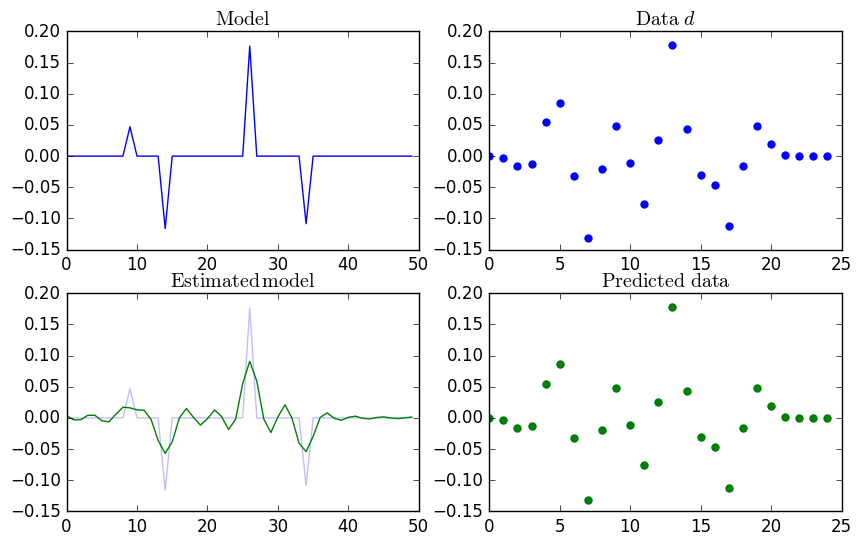

In [22]:
plot_all(m, d, m_est, d_pred)

## Direct general solver

We can use Julia's linalg [backlash operator](http://docs.julialang.org/en/release-0.5/stdlib/linalg/#Base.\) to solve the system. The operation `A \ B = x` is such that `A*x == B` when `A` is square, and when it's not square, it implements a solution via factorization.

In [23]:
m_est = G \ d 
d_pred = G * m_est;

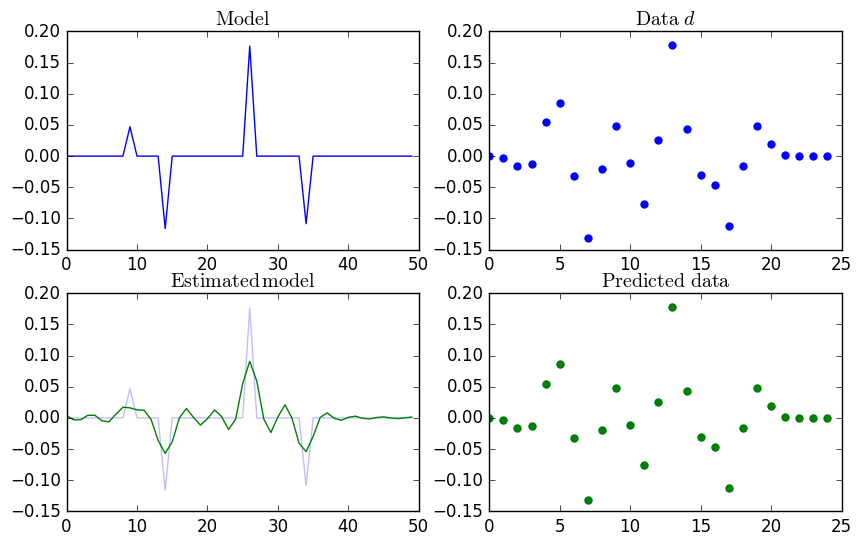

In [24]:
plot_all(m, d, m_est, d_pred)

## QR factorization

As always, this only works if **G** is square.

In [25]:
F = qrfact(G)

Base.LinAlg.QRCompactWY{Float64,Array{Float64,2}}([-1.11763 -0.923579 … -4.75542e-46 -4.09877e-48; 0.066959 -0.650178 … -1.2878e-43 -1.33141e-45; … ; 0.0 0.0 … -0.142587 0.318841; 0.0 0.0 … 1.00002 0.727125],[1.89475 -0.279441 … -1.22382e-42 0.0; 5.92879e-323 1.94842 … -2.47568e-43 0.0; … ; 2.78134e-309 NaN … 2.0 0.0; 6.92746e-310 0.0 … 3.50639e151 0.0])

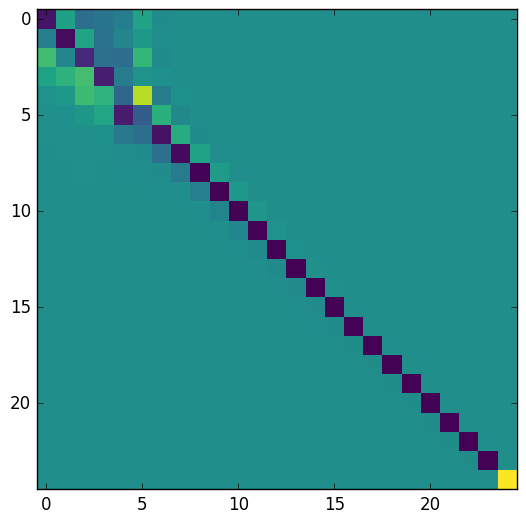

In [26]:
imshow(F[:Q], cmap="viridis", interpolation="none")
show()

In [ ]:
p = F[:Q]' * d
m_est = inv(F[:R]) * p
d_pred = G * m_est
plot_all(m, d, m_est, d_pred)

## LU Factorization

In [27]:
F = lufact(G)

Base.LinAlg.LU{Float64,Array{Float64,2}}([1.0 0.727177 … 0.0 0.0; 0.141794 0.624068 … 0.0 0.0; … ; 0.0 0.0 … 0.14275 -0.318723; 0.0 0.0 … 1.00002 0.727125],[1,2,3,4,6,6,7,8,9,10  …  16,17,18,19,20,21,22,23,24,25],0)

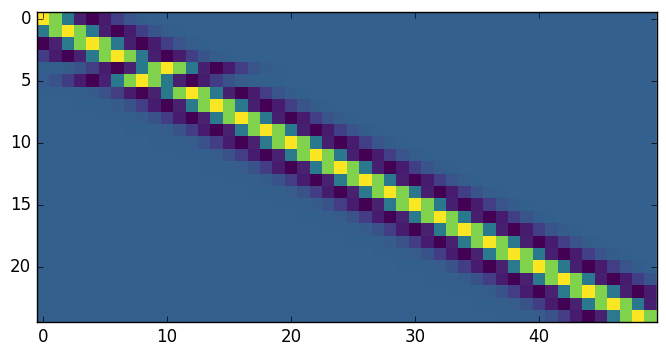

In [28]:
imshow(F[:L]*F[:U], cmap="viridis", interpolation="none")
show()

I don't think there's a method that will work for this non-square matrix, but Julia exposes [a lot of BLAS functions](http://docs.julialang.org/en/release-0.5/stdlib/linalg/#module-Base.LinAlg.BLAS). 

## Using regression methods

We'll use [ridge regression](http://multivariatestatsjl.readthedocs.io/en/latest/lreg.html#ridge-regression), also known as Tikhonov regularization.

In [34]:
using MultivariateStats

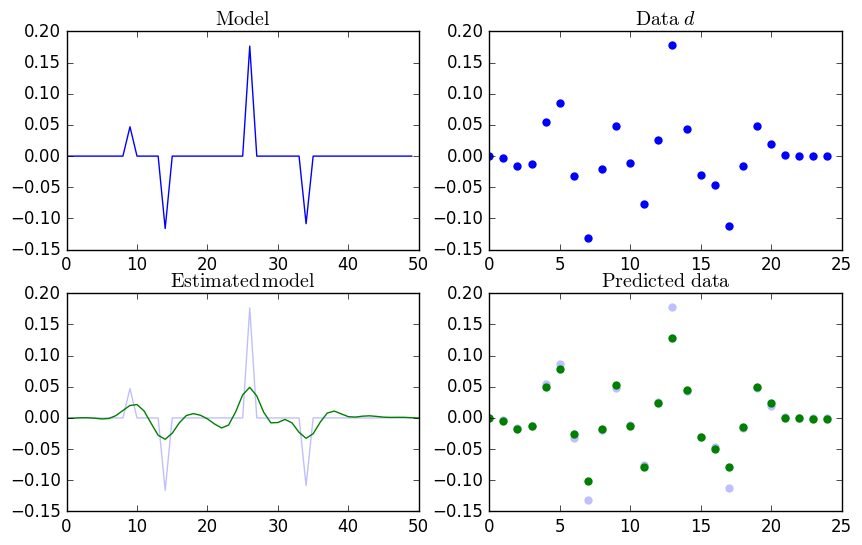

In [35]:
m_est = ridge(G, d, 1);
d_pred = G * m_est[1:end-1];
plot_all(m, d, m_est, d_pred)